*Initially created at 13.12.2017 by Petteri Nevavuori (<petteri.nevavuori@mtech.fi>)*

---

# GDAL I. Field-Wise Image Dataset Extraction

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span><ul class="toc-item"><li><span><a href="#1.1-Folder-structures" data-toc-modified-id="1.1-Folder-structures-1.1">1.1 Folder structures</a></span><ul class="toc-item"><li><span><a href="#1.1.1-Granule-folder-structure" data-toc-modified-id="1.1.1-Granule-folder-structure-1.1.1">1.1.1 Granule folder structure</a></span></li><li><span><a href="#1.1.2-Drone-folder-structure" data-toc-modified-id="1.1.2-Drone-folder-structure-1.1.2">1.1.2 Drone folder structure</a></span></li><li><span><a href="#1.1.3-Output-datasets'-folder-structure" data-toc-modified-id="1.1.3-Output-datasets'-folder-structure-1.1.3">1.1.3 Output datasets' folder structure</a></span></li></ul></li></ul></li><li><span><a href="#3.1.-Sentinel-data" data-toc-modified-id="3.1.-Sentinel-data-2">3.1. Sentinel data</a></span></li><li><span><a href="#3.2.-Drone-data" data-toc-modified-id="3.2.-Drone-data-3">3.2. Drone data</a></span><ul class="toc-item"><li><span><a href="#3.2.1-NDVI-images" data-toc-modified-id="3.2.1-NDVI-images-3.1">3.2.1 NDVI images</a></span></li><li><span><a href="#3.2.2-RGB-images" data-toc-modified-id="3.2.2-RGB-images-3.2">3.2.2 RGB images</a></span></li></ul></li><li><span><a href="#4.-Dataset-date-coverage" data-toc-modified-id="4.-Dataset-date-coverage-4">4. Dataset date coverage</a></span><ul class="toc-item"><li><span><a href="#4.1-Drone-image-dates" data-toc-modified-id="4.1-Drone-image-dates-4.1">4.1 Drone image dates</a></span></li></ul></li></ul></div>

## 1. Introduction

This notebook lays out the process of building the spatio-temporal dataset for crop field model development. For those interested in technical details, the corresponding modules and used functions can be inspected from the repository page.

The process of image dataset extraction is a multi-stepped one, where first the Sentinel-2A datasets processed for extraction of NDVI-information and reprojection from WGS84 to EPSG:3067 (a.k.a. TM35FIN). After this the fieldwise data is extracted from these NDVI-granules utilizing crop field boundaries acquired from Maaseutuvirasto (MaVi). Then the already processed and generated drone images are resampled to a resolution, where a single Sentinel 2A pixel corresponds to a 32 x 32 px area.

In the following section we will extract the NDVI form Sentinel 2A datasets.

**Note:** Field with `LOHKO` id of `6090462672` produces computational errors, as Maaseutuvirasto's shapefile dataset doesn't have any proper geometry data for year 2017. It is therefore omitted.

There are some prerequisites to make this Notebook work on other machines. First thing is to have the Sentinel Application Platform or SNAP installed and configured to use an existing Python 3.4. The SNAP installer can be found [here](http://step.esa.int/main/download/). This way the SNAP Python API can be utilized via module called `snappy`. The ``osgeo`` package is also a definite requirement along with basic data handling packages such as ``pandas`` and ``numpy``. For visualization we will use ``seaborn``, that makes use of ``matplotlib``. The last thing is to have the Sentinel 2A and drone datasets in a folder structure depicted next.

### 1.1 Folder structures

At this point the input and output files will still be served from distinct folders. The input datasets, namely the Sentinel 2A granules and Drone NDVI and RGB images, are processed from their corresponding folder structures. The outputs will be persisted to a distinct structure as well.

#### 1.1.1 Granule folder structure

The presumption is that the granules are as extracted folders in a containing folder. An example folder struct and the one used with the Notebook is as follows:

    Sentinel 2A/
        |- 2016/
        |- 2017/
            |- T35VEP/
                |- 20170603/
                |- 20170610/
                |- 20170623/
                |- ...
            |- T35VLH/
                |- ...

A point worth noting is that the names of the folders are not as concise by default when downloading the Granules from ESA. The leaf folders correspond to the dates for when the datasets were generated.

#### 1.1.2 Drone folder structure

The data for the drone files is is arranged in folders like this:

    Drone/
        |- 2016/
        |- 2017/
            |- T35VEP/
                |- 6090161366/
                |- 6090205523/
                |- 6090324751/
                |- ...
            |- T35VLH/
                |- ...

The leaf folders correspond to field block IDs, to which the date-named files are related to.

#### 1.1.3 Output datasets' folder structure

The output structure will follow the convention of ``DATASET_NAME/YEAR/GRANULE/BLOCK_ID``. An example representation and the one used in the notebook is as follows:

    Lohkodatat/
        |- 2016/
        |- 2017/
            |- T35VEP/
                |- 6090161366/
                |- 6090205523/
                |- 6090324751/
                |- ...
            |- T35VLH/
                |- ...

The leaf folders correspond to field block IDs, to which the date-named files are related to.

# 2. Prepare Sentinel-2A NDVI-images

First we extract the [NDVI](https://wikipedia.org/wiki/NDVI) from a batch of Sentinel-2 data granules.The granules are preprocessed to Level 2A as defined in-depth in documentation for [Level-2A Algorithm](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm). This means that there is no need for calculating the atmospheric correction and that the granules already contain coarse pixel-wise classification information for the following classes:

![Pre-computed classification labels for Sentinel-2 granules](https://sentinel.esa.int/documents/247904/322303/SUH-WIKI-MSI-230_Scene_Classification_figure_3.png)

We will make use of this information for extracting only the relevant classes and excluding the rest for calculating the NDVI for only the vegetation and soil data. The Sentinel-2A's corresponding NDVI equation is as follows. This function will be used in the *BandMaths* operation in the extraction process:

![Sentinel-2A's NDVI equation with corresponding bands](https://sentinel.esa.int/documents/247904/322303/Level-2A_Algorithms_Equation_2a.jpg)

The processes are executed by utilizing SNAP's Graph Processing Framework or ``GPF``. The ``GPF`` provides exactly same operations that are present in SNAP GUI's Graph Builder. The whole pipeline is constructed of the following operations:

    [Read] -> [Resample] -> [BandMaths] -> [Reproject] -> [Write]
    
Where the operations are:
 - *Read*: Read the downloaded Sentinel-2A granule.
 - *Resample*: Increase the resolution for classification information layer. Information on default resolutions for distinct bands can be found in [Sentinel-2: Resolution and Swath](https://sentinel.esa.int/web/sentinel/missions/sentinel-2/instrument-payload/resolution-and-swath).
 - *BandMaths*: Exclude non-vegetation and non-soil pixels and then calculate the NDVI. This operation also reduces the number of bands, thus reducing the computation time for Reprojection.
 - *Reproject*: The default WGS-84 coordinate system is projected into Finnish TM35 (EPSG:3067).
 - *Write*: Write the processed granule as a GTiff file.
 - *Scale*: The image is scaled upwards for sharper cutlines in the raster clipping stages later on.

The code has been built to implement these operations consecutively for each Sentinel 2A granule.

In [1]:
from field_analysis.extraction.snap_gpf import Sentinel2A

sentinel = Sentinel2A()
sentinel.extract()

Performing SNAP GPF ops on Sentinel2A Granules
Processing 20170603 from D:\Data\Sentinel 2A\2017\T35VEP\20170603\MTD_MSIL2A.xml
	Read, path=D:\Data\Sentinel 2A\2017\T35VEP\20170603\MTD_MSIL2A.xml
	Resample, product=20170603
	BandMaths, product=20170603_resampled
	Reproject, product=20170603_resampled_BandMath
	Write, file_path=D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
	Processing done in 3m 29s
Processing 20170610 from D:\Data\Sentinel 2A\2017\T35VEP\20170610\MTD_MSIL2A.xml
	Read, path=D:\Data\Sentinel 2A\2017\T35VEP\20170610\MTD_MSIL2A.xml
	Resample, product=20170610
	BandMaths, product=20170610_resampled
	Reproject, product=20170610_resampled_BandMath
	Write, file_path=D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
	Processing done in 3m 34s
Processing 20170623 from D:\Data\Sentinel 2A\2017\T35VEP\20170623\MTD_MSIL2A.xml
	Read, path=D:\Data\Sentinel 2A\2017\T35VEP\20170623\MTD_MSIL2A.xml
	Resample, product=20170623
	BandMaths, product=20170623_resampled
	

# 3. Export field wise datasets

In this section we lay out the process of extracting field-wise data from Sentinel-2A granules and drone orthomosaics with geological boundaries. After many trials and errors, the easiest solution for clipping the granules to shape boundaries was to use `gdal.Warp` almost identically to CLI-command `gdalwarp`. In essence, the utility is fed three paths (output path, input granule path and shapefile path), the OGR SQL for selecting proper shape and a boolean to enable cropping to cutline. The utility will then produce rasters corresponding to blocks' shapes.

We will also use ``gdal.Transform`` to rescale single and multi band values to a desired float range.

The output resolutions are the following:
 - **Sentinel-2A:** 10 m/px, which is the best resolution in the raw satellite dataset.
 - **Drone:** 0.3125 m/px or 10/32 m/px to have a 32x32 pixel window for each 10m x 10m area

The Sentinel-2A datasets are extracted saved with an output resolution of 10m per pixel, which is the best available resolution in the raw satellite dataset. The drone datasets have an output resolution of 10 m per 32 px to allow for handling the 10 x 10 m areas as distinct 32 x 32 px images.

Regardless of the specific implementation, the code is constructed to first build the input-output path pairs. Then the field blocks are extracted from the input images by cutting the images with block wise shapefiles.

## 3.1. Sentinel data
First we precompute all the paths to streamline the clipping process and create non-existent containing folders for generated datasets. Thus we iterate over each granule and each block to extract the field-wise NDVI-data only.

6090006368	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006368\20170603_sentinel_ndvi.tif


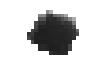

6090006469	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006469\20170603_sentinel_ndvi.tif


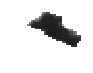

6090161265	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161265\20170603_sentinel_ndvi.tif


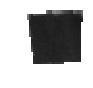

6090161366	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170603_sentinel_ndvi.tif


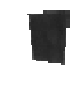

6090205523	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170603_sentinel_ndvi.tif


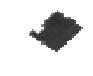

6090324751	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170603_sentinel_ndvi.tif


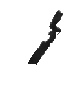

6090328993	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170603_sentinel_ndvi.tif


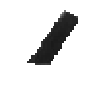

6090340818	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090340818\20170603_sentinel_ndvi.tif


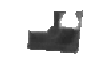

6090342838	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090342838\20170603_sentinel_ndvi.tif


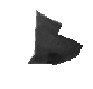

6090345161	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170603_sentinel_ndvi.tif


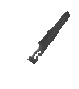

6090345969	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170603_sentinel_ndvi.tif


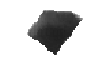

6090346171	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170603_sentinel_ndvi.tif


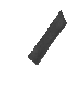

6090347888	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170603_sentinel_ndvi.tif


6090348292	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090348292\20170603_sentinel_ndvi.tif


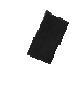

6090672133	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170603_sentinel_ndvi.tif


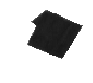

8860017483	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170603_sentinel_ndvi.tif


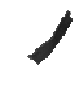

8860091851	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860091851\20170603_sentinel_ndvi.tif


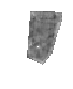

8860095891	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170603_sentinel_ndvi.tif


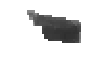

8860095992	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170603_sentinel_ndvi.tif


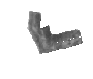

8860195925	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860195925\20170603_sentinel_ndvi.tif


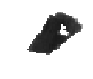

9880016034	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016034\20170603_sentinel_ndvi.tif


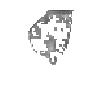

9880016135	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016135\20170603_sentinel_ndvi.tif


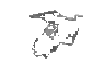

9880167291	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880167291\20170603_sentinel_ndvi.tif


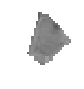

9880217714	From	D:\Data\Sentinel 2A\2017\T35VEP\20170603_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880217714\20170603_sentinel_ndvi.tif


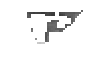

6090006368	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006368\20170610_sentinel_ndvi.tif


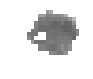

6090006469	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006469\20170610_sentinel_ndvi.tif


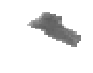

6090161265	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161265\20170610_sentinel_ndvi.tif


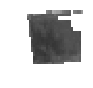

6090161366	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170610_sentinel_ndvi.tif


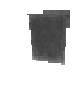

6090205523	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170610_sentinel_ndvi.tif


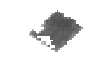

6090324751	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170610_sentinel_ndvi.tif


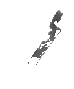

6090328993	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170610_sentinel_ndvi.tif


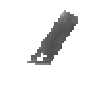

6090340818	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090340818\20170610_sentinel_ndvi.tif


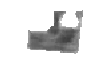

6090342838	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090342838\20170610_sentinel_ndvi.tif


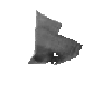

6090345161	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170610_sentinel_ndvi.tif


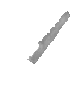

6090345969	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170610_sentinel_ndvi.tif


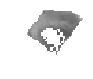

6090346171	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170610_sentinel_ndvi.tif


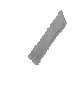

6090347888	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170610_sentinel_ndvi.tif


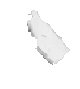

6090348292	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090348292\20170610_sentinel_ndvi.tif


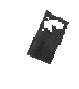

6090672133	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170610_sentinel_ndvi.tif


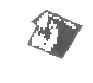

8860017483	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170610_sentinel_ndvi.tif


8860091851	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860091851\20170610_sentinel_ndvi.tif


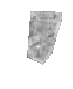

8860095891	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170610_sentinel_ndvi.tif


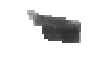

8860095992	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170610_sentinel_ndvi.tif


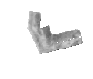

8860195925	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860195925\20170610_sentinel_ndvi.tif


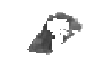

9880016034	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880016135	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880167291	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880217714	From	D:\Data\Sentinel 2A\2017\T35VEP\20170610_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880217714\20170610_sentinel_ndvi.tif


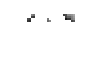

6090006368	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006368\20170623_sentinel_ndvi.tif


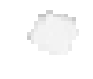

6090006469	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006469\20170623_sentinel_ndvi.tif


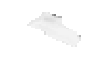

6090161265	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161265\20170623_sentinel_ndvi.tif


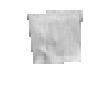

6090161366	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170623_sentinel_ndvi.tif


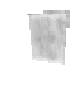

6090205523	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170623_sentinel_ndvi.tif


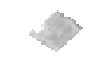

6090324751	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170623_sentinel_ndvi.tif


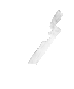

6090328993	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170623_sentinel_ndvi.tif


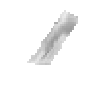

6090340818	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090340818\20170623_sentinel_ndvi.tif


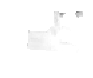

6090342838	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090342838\20170623_sentinel_ndvi.tif


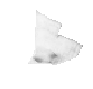

6090345161	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170623_sentinel_ndvi.tif


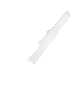

6090345969	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170623_sentinel_ndvi.tif


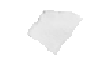

6090346171	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170623_sentinel_ndvi.tif


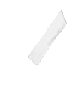

6090347888	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170623_sentinel_ndvi.tif


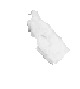

6090348292	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090348292\20170623_sentinel_ndvi.tif


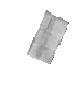

6090672133	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170623_sentinel_ndvi.tif


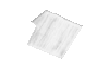

8860017483	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170623_sentinel_ndvi.tif


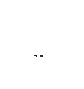

8860091851	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860091851\20170623_sentinel_ndvi.tif


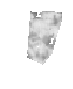

8860095891	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170623_sentinel_ndvi.tif


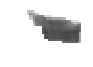

8860095992	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170623_sentinel_ndvi.tif


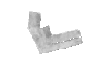

8860195925	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880016034	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016034\20170623_sentinel_ndvi.tif


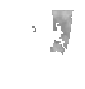

9880016135	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016135\20170623_sentinel_ndvi.tif


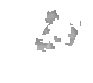

9880167291	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880167291\20170623_sentinel_ndvi.tif


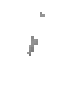

9880217714	From	D:\Data\Sentinel 2A\2017\T35VEP\20170623_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880217714\20170623_sentinel_ndvi.tif


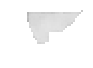

6090006368	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006368\20170630_sentinel_ndvi.tif


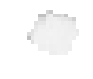

6090006469	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006469\20170630_sentinel_ndvi.tif


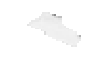

6090161265	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161265\20170630_sentinel_ndvi.tif


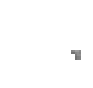

6090161366	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090205523	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170630_sentinel_ndvi.tif


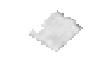

6090324751	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170630_sentinel_ndvi.tif


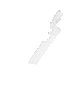

6090328993	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170630_sentinel_ndvi.tif


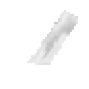

6090340818	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090340818\20170630_sentinel_ndvi.tif


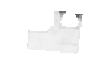

6090342838	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090345161	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170630_sentinel_ndvi.tif


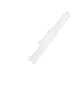

6090345969	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170630_sentinel_ndvi.tif


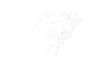

6090346171	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170630_sentinel_ndvi.tif


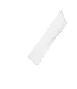

6090347888	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170630_sentinel_ndvi.tif


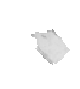

6090348292	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090348292\20170630_sentinel_ndvi.tif


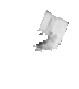

6090672133	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170630_sentinel_ndvi.tif


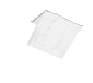

8860017483	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170630_sentinel_ndvi.tif


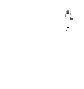

8860091851	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860091851\20170630_sentinel_ndvi.tif


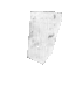

8860095891	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
8860095992	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
8860195925	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860195925\20170630_sentinel_ndvi.tif


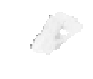

9880016034	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016034\20170630_sentinel_ndvi.tif


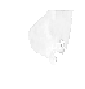

9880016135	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016135\20170630_sentinel_ndvi.tif


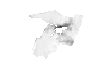

9880167291	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880167291\20170630_sentinel_ndvi.tif


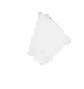

9880217714	From	D:\Data\Sentinel 2A\2017\T35VEP\20170630_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880217714\20170630_sentinel_ndvi.tif


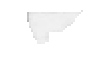

6090006368	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090006469	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090161265	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161265\20170720_sentinel_ndvi.tif


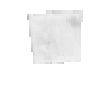

6090161366	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170720_sentinel_ndvi.tif


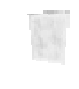

6090205523	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090324751	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090328993	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090340818	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090340818\20170720_sentinel_ndvi.tif


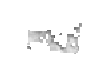

6090342838	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090342838\20170720_sentinel_ndvi.tif


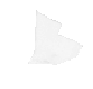

6090345161	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170720_sentinel_ndvi.tif


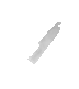

6090345969	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170720_sentinel_ndvi.tif


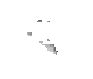

6090346171	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170720_sentinel_ndvi.tif


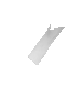

6090347888	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170720_sentinel_ndvi.tif


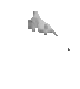

6090348292	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090348292\20170720_sentinel_ndvi.tif


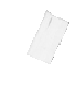

6090672133	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170720_sentinel_ndvi.tif


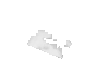

8860017483	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170720_sentinel_ndvi.tif


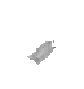

8860091851	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860091851\20170720_sentinel_ndvi.tif


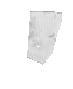

8860095891	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170720_sentinel_ndvi.tif


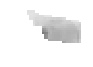

8860095992	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170720_sentinel_ndvi.tif


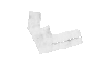

8860195925	From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860195925\20170720_sentinel_ndvi.tif


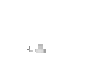

9880016034	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880016135	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880167291	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880217714	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170720_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090006368	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090006469	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006469\20170723_sentinel_ndvi.tif


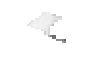

6090161265	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161265\20170723_sentinel_ndvi.tif


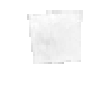

6090161366	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170723_sentinel_ndvi.tif


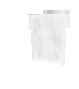

6090205523	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170723_sentinel_ndvi.tif


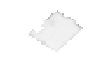

6090324751	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170723_sentinel_ndvi.tif


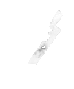

6090328993	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170723_sentinel_ndvi.tif


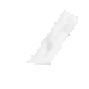

6090340818	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090340818\20170723_sentinel_ndvi.tif


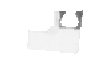

6090342838	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090342838\20170723_sentinel_ndvi.tif


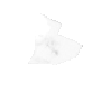

6090345161	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170723_sentinel_ndvi.tif


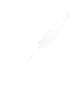

6090345969	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170723_sentinel_ndvi.tif


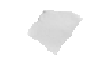

6090346171	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170723_sentinel_ndvi.tif


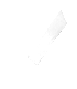

6090347888	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170723_sentinel_ndvi.tif


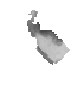

6090348292	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090348292\20170723_sentinel_ndvi.tif


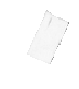

6090672133	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170723_sentinel_ndvi.tif


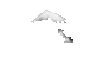

8860017483	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170723_sentinel_ndvi.tif


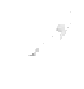

8860091851	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860091851\20170723_sentinel_ndvi.tif


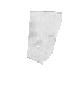

8860095891	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170723_sentinel_ndvi.tif


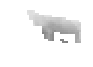

8860095992	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170723_sentinel_ndvi.tif


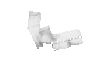

8860195925	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860195925\20170723_sentinel_ndvi.tif


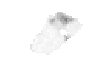

9880016034	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016034\20170723_sentinel_ndvi.tif


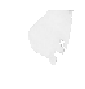

9880016135	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016135\20170723_sentinel_ndvi.tif


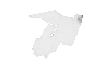

9880167291	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880167291\20170723_sentinel_ndvi.tif


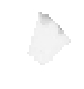

9880217714	From	D:\Data\Sentinel 2A\2017\T35VEP\20170723_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880217714\20170723_sentinel_ndvi.tif


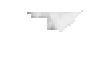

6090006368	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006368\20170911_sentinel_ndvi.tif


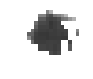

6090006469	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090006469\20170911_sentinel_ndvi.tif


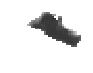

6090161265	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161265\20170911_sentinel_ndvi.tif


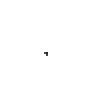

6090161366	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170911_sentinel_ndvi.tif


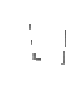

6090205523	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170911_sentinel_ndvi.tif


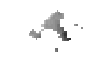

6090324751	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170911_sentinel_ndvi.tif


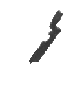

6090328993	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170911_sentinel_ndvi.tif


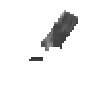

6090340818	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090340818\20170911_sentinel_ndvi.tif


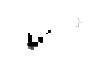

6090342838	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090342838\20170911_sentinel_ndvi.tif


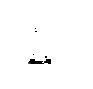

6090345161	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090345969	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170911_sentinel_ndvi.tif


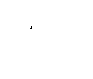

6090346171	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090347888	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170911_sentinel_ndvi.tif


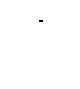

6090348292	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
6090672133	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170911_sentinel_ndvi.tif


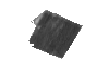

8860017483	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
8860091851	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860091851\20170911_sentinel_ndvi.tif


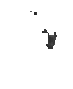

8860095891	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170911_sentinel_ndvi.tif


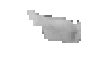

8860095992	From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170911_sentinel_ndvi.tif


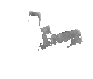

8860195925	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880016034	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880016135	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880167291	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
9880217714	Error (warp): Warped image contains only NaNs
		From	D:\Data\Sentinel 2A\2017\T35VEP\20170911_sentinel_ndvi.tif
		To	D:\Data\Temp\temp.tif
Processed 141 field blocks in 36m 25s
Asserting filenames: All generated block datasets named correctly!


In [1]:
import numpy as np
from field_analysis.extraction.blocks import Sentinel2ANDVI

sentinel_ndvi = Sentinel2ANDVI(target_resolution=10, source_range=(-1,1), 
                           dest_range=(-1,1),source_nodata=np.nan)
sentinel_ndvi.extract()

## 3.2. Drone data

In this section we will iterate over fields with data recorded by drones. The data is either in NDVI or RGB. The images are large by default and are thus downsampled to math the resolution of the Sentinel images.


                
The numbers under granules are the fields' block IDs.

Like previously, we first precompute all the necessary paths. Then we iterate over each drone data folder with a process similar to the preceding section. The filenames are in the following format:

    YYYYMMDD_format.tif

The `format` is either `ndvi` or `rgb`, according to the image's datatype and the source value ranges correspond with the datatype. These files are in their corresponding block IDs' folder roots.

### 3.2.1 NDVI images

6090161366	From	D:\Data\Drone\2017\T35VEP\6090161366\20170821_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170821_drone_ndvi.tif


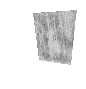

6090205523	From	D:\Data\Drone\2017\T35VEP\6090205523\20170614_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170614_drone_ndvi.tif


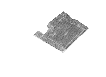

6090205523	From	D:\Data\Drone\2017\T35VEP\6090205523\20170729_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170729_drone_ndvi.tif


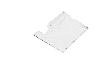

6090324751	From	D:\Data\Drone\2017\T35VEP\6090324751\20170609_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170609_drone_ndvi.tif


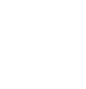

6090324751	From	D:\Data\Drone\2017\T35VEP\6090324751\20170613_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170613_drone_ndvi.tif


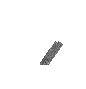

6090324751	From	D:\Data\Drone\2017\T35VEP\6090324751\20170729_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170729_drone_ndvi.tif


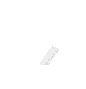

6090328993	From	D:\Data\Drone\2017\T35VEP\6090328993\20170609_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170609_drone_ndvi.tif


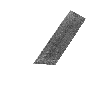

6090328993	From	D:\Data\Drone\2017\T35VEP\6090328993\20170729_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170729_drone_ndvi.tif


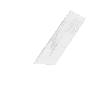

6090342838	From	D:\Data\Drone\2017\T35VEP\6090342838\20170707_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090342838\20170707_drone_ndvi.tif


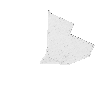

6090345161	From	D:\Data\Drone\2017\T35VEP\6090345161\20170619_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170619_drone_ndvi.tif


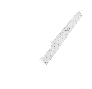

6090345969	From	D:\Data\Drone\2017\T35VEP\6090345969\20170628_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170628_drone_ndvi.tif


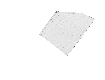

6090345969	From	D:\Data\Drone\2017\T35VEP\6090345969\20170727_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170727_drone_ndvi.tif


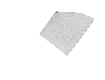

6090346171	From	D:\Data\Drone\2017\T35VEP\6090346171\20170619_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170619_drone_ndvi.tif


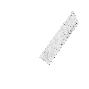

6090347888	From	D:\Data\Drone\2017\T35VEP\6090347888\20170628_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170628_drone_ndvi.tif


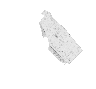

6090347888	From	D:\Data\Drone\2017\T35VEP\6090347888\20170727_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170727_drone_ndvi.tif


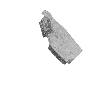

6090348292	From	D:\Data\Drone\2017\T35VEP\6090348292\20170707_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090348292\20170707_drone_ndvi.tif


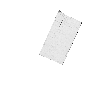

6090672133	From	D:\Data\Drone\2017\T35VEP\6090672133\20170606_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170606_drone_ndvi.tif


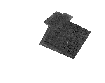

6090672133	From	D:\Data\Drone\2017\T35VEP\6090672133\20170718_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170718_drone_ndvi.tif


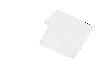

8860017483	From	D:\Data\Drone\2017\T35VEP\8860017483\20170729_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170729_drone_ndvi.tif


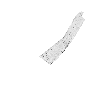

8860095891	From	D:\Data\Drone\2017\T35VEP\8860095891\20170814_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170814_drone_ndvi.tif


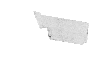

8860095992	From	D:\Data\Drone\2017\T35VEP\8860095992\20170615_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170615_drone_ndvi.tif


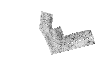

8860195925	From	D:\Data\Drone\2017\T35VEP\8860195925\20170729_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\8860195925\20170729_drone_ndvi.tif


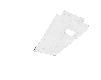

9880016034	From	D:\Data\Drone\2017\T35VEP\9880016034\20170629_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016034\20170629_drone_ndvi.tif


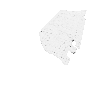

9880217714	From	D:\Data\Drone\2017\T35VEP\9880217714\20170716_drone_ndvi.tif
		To	D:\Data\Blocks\2017\T35VEP\9880217714\20170716_drone_ndvi.tif


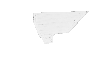

Processed 24 field blocks in 8m 49s
Asserting filenames: All generated block datasets named correctly!


In [ ]:
from field_analysis.extraction.blocks import DroneNDVI

drone_ndvi = DroneNDVI(target_resolution=10/32, source_range=(-1,1), 
                       dest_range=(-1,1), source_nodata=-10000)
drone_ndvi.extract()

### 3.2.2 RGB images

6090161366	From	D:\Data\Drone\2017\T35VEP\6090161366\20170821_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090161366\20170821_drone_rgb.tif


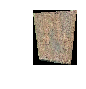

6090205523	From	D:\Data\Drone\2017\T35VEP\6090205523\20170614_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170614_drone_rgb.tif


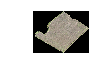

6090205523	From	D:\Data\Drone\2017\T35VEP\6090205523\20170729_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090205523\20170729_drone_rgb.tif


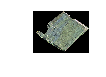

6090324751	From	D:\Data\Drone\2017\T35VEP\6090324751\20170609_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170609_drone_rgb.tif


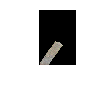

6090324751	From	D:\Data\Drone\2017\T35VEP\6090324751\20170729_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090324751\20170729_drone_rgb.tif


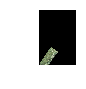

6090328993	From	D:\Data\Drone\2017\T35VEP\6090328993\20170609_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170609_drone_rgb.tif


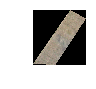

6090328993	From	D:\Data\Drone\2017\T35VEP\6090328993\20170729_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090328993\20170729_drone_rgb.tif


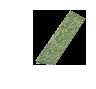

6090342838	Error (warp): 'NoneType' object has no attribute 'ReadAsArray'
		From	D:\Data\Drone\2017\T35VEP\6090342838\20170707_drone_rgb.tif
		To	D:\Data\Temp\temp.tif
6090345161	From	D:\Data\Drone\2017\T35VEP\6090345161\20170619_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345161\20170619_drone_rgb.tif


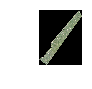

6090345969	From	D:\Data\Drone\2017\T35VEP\6090345969\20170628_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170628_drone_rgb.tif


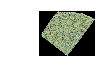

6090345969	From	D:\Data\Drone\2017\T35VEP\6090345969\20170727_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090345969\20170727_drone_rgb.tif


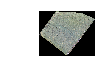

6090346171	From	D:\Data\Drone\2017\T35VEP\6090346171\20170619_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090346171\20170619_drone_rgb.tif


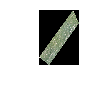

6090347888	From	D:\Data\Drone\2017\T35VEP\6090347888\20170628_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170628_drone_rgb.tif


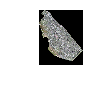

6090347888	From	D:\Data\Drone\2017\T35VEP\6090347888\20170727_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090347888\20170727_drone_rgb.tif


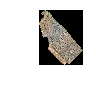

6090348292	Error (warp): 'NoneType' object has no attribute 'ReadAsArray'
		From	D:\Data\Drone\2017\T35VEP\6090348292\20170707_drone_rgb.tif
		To	D:\Data\Temp\temp.tif
6090672133	From	D:\Data\Drone\2017\T35VEP\6090672133\20170606_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170606_drone_rgb.tif


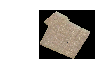

6090672133	From	D:\Data\Drone\2017\T35VEP\6090672133\20170718_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\6090672133\20170718_drone_rgb.tif


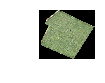

8860017483	From	D:\Data\Drone\2017\T35VEP\8860017483\20170729_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\8860017483\20170729_drone_rgb.tif


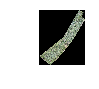

8860095891	From	D:\Data\Drone\2017\T35VEP\8860095891\20170817_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095891\20170817_drone_rgb.tif


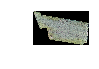

8860095992	From	D:\Data\Drone\2017\T35VEP\8860095992\20170615_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170615_drone_rgb.tif


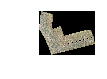

8860095992	From	D:\Data\Drone\2017\T35VEP\8860095992\20170710_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\8860095992\20170710_drone_rgb.tif


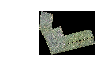

8860195925	From	D:\Data\Drone\2017\T35VEP\8860195925\20170729_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\8860195925\20170729_drone_rgb.tif


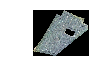

9880016034	From	D:\Data\Drone\2017\T35VEP\9880016034\20170629_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\9880016034\20170629_drone_rgb.tif


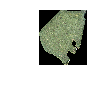

9880217714	From	D:\Data\Drone\2017\T35VEP\9880217714\20170716_drone_rgb.tif
		To	D:\Data\Blocks\2017\T35VEP\9880217714\20170716_drone_rgb.tif


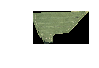

Processed 22 field blocks in 260m 27s
Asserting filenames: All generated block datasets named correctly!


In [1]:
from field_analysis.extraction.blocks import DroneRGB

drone_rgb = DroneRGB(target_resolution=10/32, source_range=(0,255),   
                     dest_range=(0,1), source_nodata=0)
drone_rgb.extract()

## 4. Dataset date coverage

Here we then map out the dates for distinct file types where there exists a dataset. We will go through individual block fields, as they represent the real time series datasets and are thus of greater importance. The daterange is presumed to be known a priori.

In this step visualize we the data coverage in the field- and date-wise images for NDVI datasets. Reason for addressing the datasets in NDVI exclusively is that the only partial datasets originate from satellite sources due to possible cloud masks. When the data source isn't satellite, the proportion of currant data in the shape boundaries is assumed at 100%.

The code is divided here to two parts, to the data coverage calculations and to the visualization. The first block of code is a modified implementation of the tutorial [Calculate zonal statistics](https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#calculate-zonal-statistics). The other makes use of ``seaborn`` packages ``heatmap`` functionality to visualize the relative data coverage day wise.

Calculating overall data coverage
.............................................................................................................................................
Drawing the heatmap


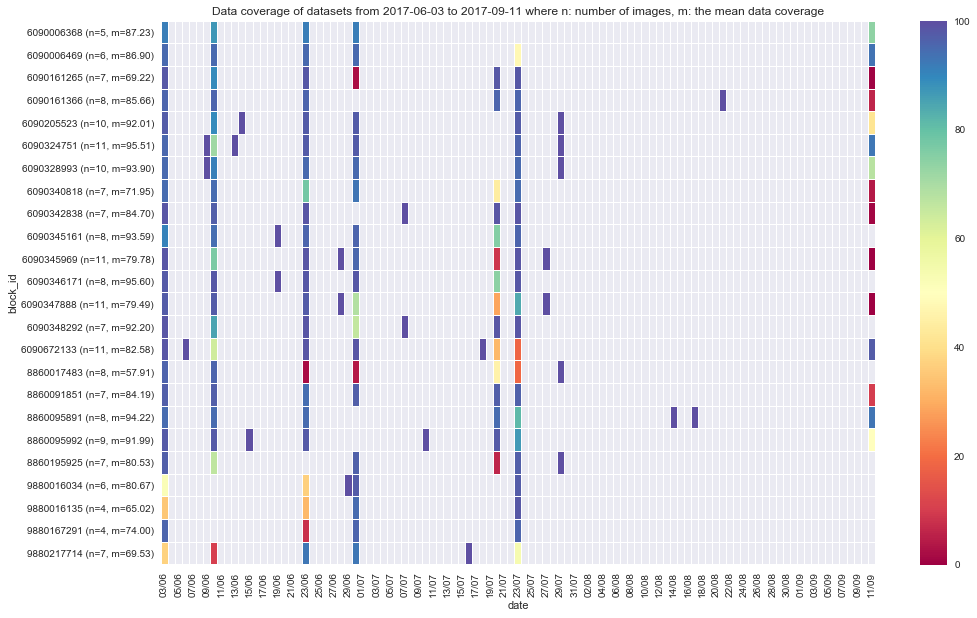

In [2]:
from field_analysis.extraction import coverage

coverage.draw_heatmap()

### 4.1 Drone image dates

We also print out the dates of imaging in readily usable LaTEX table format.

In [75]:
import datetime
import numpy as np
output='''6090161366 From D:\\Data\\Drone\\2017\\T35VEP\\6090161366\\20170821_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090161366\\20170821_drone_rgb.tif

6090205523 From D:\\Data\\Drone\\2017\\T35VEP\\6090205523\\20170614_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090205523\\20170614_drone_rgb.tif

6090205523 From D:\\Data\\Drone\\2017\\T35VEP\\6090205523\\20170729_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090205523\\20170729_drone_rgb.tif

6090324751 From D:\\Data\\Drone\\2017\\T35VEP\\6090324751\\20170609_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090324751\\20170609_drone_rgb.tif

6090324751 From D:\\Data\\Drone\\2017\\T35VEP\\6090324751\\20170729_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090324751\\20170729_drone_rgb.tif

6090328993 From D:\\Data\\Drone\\2017\\T35VEP\\6090328993\\20170609_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090328993\\20170609_drone_rgb.tif

6090328993 From D:\\Data\\Drone\\2017\\T35VEP\\6090328993\\20170729_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090328993\\20170729_drone_rgb.tif

6090342838 Error (warp): 'NoneType' object has no attribute 'ReadAsArray'
  From D:\\Data\\Drone\\2017\\T35VEP\\6090342838\\20170707_drone_rgb.tif
  To D:\\Data\\Temp\\temp.tif
  
6090345161 From D:\\Data\\Drone\\2017\\T35VEP\\6090345161\\20170619_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090345161\\20170619_drone_rgb.tif

6090345969 From D:\\Data\\Drone\\2017\\T35VEP\\6090345969\\20170628_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090345969\\20170628_drone_rgb.tif

6090345969 From D:\\Data\\Drone\\2017\\T35VEP\\6090345969\\20170727_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090345969\\20170727_drone_rgb.tif

6090346171 From D:\\Data\\Drone\\2017\\T35VEP\\6090346171\\20170619_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090346171\\20170619_drone_rgb.tif

6090347888 From D:\\Data\\Drone\\2017\\T35VEP\\6090347888\\20170628_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090347888\\20170628_drone_rgb.tif

6090347888 From D:\\Data\\Drone\\2017\\T35VEP\\6090347888\\20170727_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090347888\\20170727_drone_rgb.tif

6090348292 Error (warp): 'NoneType' object has no attribute 'ReadAsArray'
  From D:\\Data\\Drone\\2017\\T35VEP\\6090348292\\20170707_drone_rgb.tif
  To D:\\Data\\Temp\\temp.tif
  
6090672133 From D:\\Data\\Drone\\2017\\T35VEP\\6090672133\\20170606_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090672133\\20170606_drone_rgb.tif

6090672133 From D:\\Data\\Drone\\2017\\T35VEP\\6090672133\\20170718_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090672133\\20170718_drone_rgb.tif

8860017483 From D:\\Data\\Drone\\2017\\T35VEP\\8860017483\\20170729_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860017483\\20170729_drone_rgb.tif

8860095891 From D:\\Data\\Drone\\2017\\T35VEP\\8860095891\\20170817_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860095891\\20170817_drone_rgb.tif

8860095992 From D:\\Data\\Drone\\2017\\T35VEP\\8860095992\\20170615_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860095992\\20170615_drone_rgb.tif

8860095992 From D:\\Data\\Drone\\2017\\T35VEP\\8860095992\\20170710_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860095992\\20170710_drone_rgb.tif

8860195925 From D:\\Data\\Drone\\2017\\T35VEP\\8860195925\\20170729_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860195925\\20170729_drone_rgb.tif

9880016034 From D:\\Data\\Drone\\2017\\T35VEP\\9880016034\\20170629_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\9880016034\\20170629_drone_rgb.tif

9880217714 From D:\\Data\\Drone\\2017\\T35VEP\\9880217714\\20170716_drone_rgb.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\9880217714\\20170716_drone_rgb.tif
  
6090161366 From D:\\Data\\Drone\\2017\\T35VEP\\6090161366\\20170821_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090161366\\20170821_drone_ndvi.tif

6090205523 From D:\\Data\\Drone\\2017\\T35VEP\\6090205523\\20170614_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090205523\\20170614_drone_ndvi.tif

6090205523 From D:\\Data\\Drone\\2017\\T35VEP\\6090205523\\20170729_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090205523\\20170729_drone_ndvi.tif

6090324751 From D:\\Data\\Drone\\2017\\T35VEP\\6090324751\\20170609_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090324751\\20170609_drone_ndvi.tif

6090324751 From D:\\Data\\Drone\\2017\\T35VEP\\6090324751\\20170613_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090324751\\20170613_drone_ndvi.tif

6090324751 From D:\\Data\\Drone\\2017\\T35VEP\\6090324751\\20170729_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090324751\\20170729_drone_ndvi.tif

6090328993 From D:\\Data\\Drone\\2017\\T35VEP\\6090328993\\20170609_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090328993\\20170609_drone_ndvi.tif

6090328993 From D:\\Data\\Drone\\2017\\T35VEP\\6090328993\\20170729_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090328993\\20170729_drone_ndvi.tif

6090342838 From D:\\Data\\Drone\\2017\\T35VEP\\6090342838\\20170707_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090342838\\20170707_drone_ndvi.tif

6090345161 From D:\\Data\\Drone\\2017\\T35VEP\\6090345161\\20170619_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090345161\\20170619_drone_ndvi.tif

6090345969 From D:\\Data\\Drone\\2017\\T35VEP\\6090345969\\20170628_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090345969\\20170628_drone_ndvi.tif

6090345969 From D:\\Data\\Drone\\2017\\T35VEP\\6090345969\\20170727_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090345969\\20170727_drone_ndvi.tif

6090346171 From D:\\Data\\Drone\\2017\\T35VEP\\6090346171\\20170619_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090346171\\20170619_drone_ndvi.tif

6090347888 From D:\\Data\\Drone\\2017\\T35VEP\\6090347888\\20170628_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090347888\\20170628_drone_ndvi.tif

6090347888 From D:\\Data\\Drone\\2017\\T35VEP\\6090347888\\20170727_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090347888\\20170727_drone_ndvi.tif

6090348292 From D:\\Data\\Drone\\2017\\T35VEP\\6090348292\\20170707_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090348292\\20170707_drone_ndvi.tif

6090672133 From D:\\Data\\Drone\\2017\\T35VEP\\6090672133\\20170606_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090672133\\20170606_drone_ndvi.tif

6090672133 From D:\\Data\\Drone\\2017\\T35VEP\\6090672133\\20170718_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\6090672133\\20170718_drone_ndvi.tif

8860017483 From D:\\Data\\Drone\\2017\\T35VEP\\8860017483\\20170729_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860017483\\20170729_drone_ndvi.tif

8860095891 From D:\\Data\\Drone\\2017\\T35VEP\\8860095891\\20170814_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860095891\\20170814_drone_ndvi.tif

8860095992 From D:\\Data\\Drone\\2017\\T35VEP\\8860095992\\20170615_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860095992\\20170615_drone_ndvi.tif

8860195925 From D:\\Data\\Drone\\2017\\T35VEP\\8860195925\\20170729_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\8860195925\\20170729_drone_ndvi.tif

9880016034 From D:\\Data\\Drone\\2017\\T35VEP\\9880016034\\20170629_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\9880016034\\20170629_drone_ndvi.tif

9880217714 From D:\\Data\\Drone\\2017\\T35VEP\\9880217714\\20170716_drone_ndvi.tif
  To D:\\Data\\Blocks\\2017\\T35VEP\\9880217714\\20170716_drone_ndvi.tif'''
output = [l.rstrip() for l in output.rsplit("\n") if len(l) > 0]
output = [l.rstrip() for l in output if len(l) > 0]
output = [l for l in output if l[0] != ' ']
output = [l.split('\\')[-1].split('.')[0] for l in output if l[-4:] == '.tif']
output = [l.split("_")[0] for l in output]

dates = []
[dates.append(l) for l in output if l not in dates]
dates = np.sort([datetime.datetime(int(d[:4]),int(d[4:6]),int(d[6:8])) for d in dates])

latex_date = []
latex_earlier = []
latex_later = []
for date in dates:
    
    d  = str(date)[:10].split('-')
    latex_date.append('\\rotatebox{{90}}{{{}.{}}}'.format(d[2],d[1]))
    if date < datetime.datetime(2017,7,1):
        latex_earlier.append('x')
        latex_later.append('')
    else:
        latex_earlier.append('')
        latex_later.append('x')

print("\t& "+"\t& ".join(latex_date)+"\\\\ \\hline")
print("\\textbf{{Earlier}}\t& "+"\t& ".join(latex_earlier)+"\\\\ \\hline")
print("\\textbf{{Later}}\t& "+"\t& ".join(latex_later)+"\\\\ \\hline")
        

	& \rotatebox{90}{06.06}	& \rotatebox{90}{09.06}	& \rotatebox{90}{13.06}	& \rotatebox{90}{14.06}	& \rotatebox{90}{15.06}	& \rotatebox{90}{19.06}	& \rotatebox{90}{28.06}	& \rotatebox{90}{29.06}	& \rotatebox{90}{07.07}	& \rotatebox{90}{10.07}	& \rotatebox{90}{16.07}	& \rotatebox{90}{18.07}	& \rotatebox{90}{27.07}	& \rotatebox{90}{29.07}	& \rotatebox{90}{14.08}	& \rotatebox{90}{17.08}	& \rotatebox{90}{21.08}\\ \hline
\textbf{{Earlier}}	& x	& x	& x	& x	& x	& x	& x	& x	& 	& 	& 	& 	& 	& 	& 	& 	& \\ \hline
\textbf{{Later}}	& 	& 	& 	& 	& 	& 	& 	& 	& x	& x	& x	& x	& x	& x	& x	& x	& x\\ \hline


In [69]:
"l "*17+"l"

'l l l l l l l l l l l l l l l l l l'